# MLP with floating point weights and baremetal C implementation

In [11]:
import sys
import time
import serial
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

import src.python.dataset.yalefaces as yalefaces
import src.python.model.util as util

np.random.seed(99)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load dataset
### Load and normalize the raw dataset

In [13]:
X, y = yalefaces.load("dataset/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

### Split into train and test datasets

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [15]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

### Compress dataset with PCA
Computing PCA parameters from the whole dataset for educational purposes only.

In [16]:
num_train_faces, num_pixels = X_train_raw.shape
num_principal_components = int(num_train_faces)
pca = PCA(n_components=num_principal_components)

pca.fit(X)

X_train = pca.transform(X_train_raw)
X_test = pca.transform(X_test_raw)

In [22]:
print(num_pixels, num_principal_components)

77760 132


<Figure size 640x480 with 0 Axes>

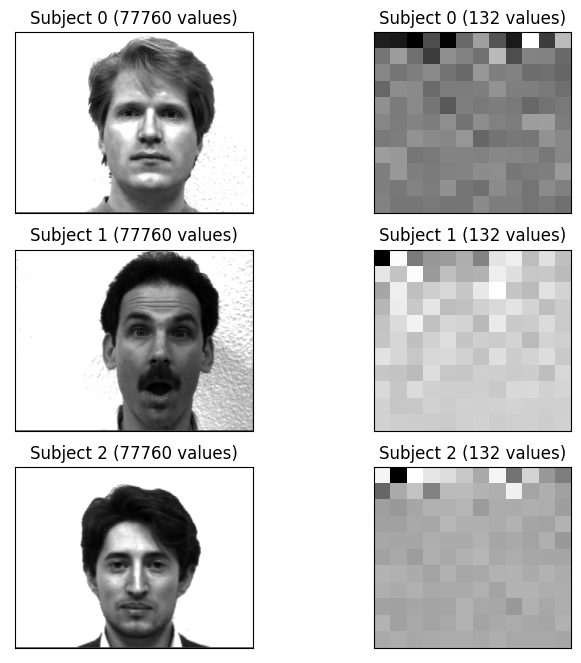

In [37]:
def plot_compressed(faces, comp_faces, labels, original_shape=(243, 320), compressed_shape=(11,12), subjects=[0,1,2]):
    plt.figure()
    
    _, axes = plt.subplots(len(subjects), 2, figsize=(8, 8), sharey=False)

    for (ax0, ax1), subject in zip(axes, subjects):
        original = faces[labels==subject][0]
        compressed = comp_faces[labels==subject][0]

        ax0.imshow(original.reshape(original_shape), cmap='gray')
        ax1.imshow(compressed.reshape(compressed_shape), cmap='gray')

        ax0.set_title(f"Subject {subject} ({original_shape[0]*original_shape[1]} values)", size=12)
        ax1.set_title(f"Subject {subject} ({compressed_shape[0] * compressed_shape[1]} values)", size=12)

        ax0.set_xticks([])
        ax0.set_yticks([])

        ax1.set_xticks([])
        ax1.set_yticks([])

    plt.show()
plot_compressed(X_train_raw, X_train, y_train)

### Convert datasets to pythorch tensors

In [17]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

## Train MLP

In [18]:
class MLP(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(132, 96, bias=False),
      torch.nn.ReLU(),
      torch.nn.Linear(96, 15, bias=False),
    )

  def forward(self, x):
    return self.layers(x)

In [19]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [20]:
train_accs= []
train_losses = []

model.to(device=device)
for epoch in range(200):
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)

    error, num_samples = util.train(model, device, train_data, optimizer)
    loss = float(error)/float(num_samples)
    train_losses.append(loss)

    acc = util.test(model, device, train_data)
    train_accs.append(acc)

In [21]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = util.test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")

Test accuracy: 81.82


## Export model weights as C code

In [ ]:
model_params=model.state_dict()

In [ ]:
layer_indexes = [0, 2]

src_filename = 'src/embedded/1-mlp-baremetal-float/esp32s3/main/mlp_weights.c'
hdr_filename = 'src/embedded/1-mlp-baremetal-float/esp32s3/include/mlp_weights.h'

with open(src_filename, 'w') as source, open(hdr_filename, 'w') as header:
    
    header.write('#ifndef MLP_WEIGHTS\n#define MLP_WEIGHTS\n\n')
    header.write('#include <stdint.h>\n\n')
    
    source.write('#include "mlp_weights.h"\n\n')

    for layer in layer_indexes:
        weights = util.get_weights(model_params, layer).flatten()

        # Weights
        header.write(f"extern const float layer_{layer}_weights[{len(weights)}];\n")
        source.write(f"const float layer_{layer}_weights[{len(weights)}] = {{")
        for i in range(len(weights)-1):
            source.write(f"{weights[i]}, ")
        source.write(f"{weights[len(weights)-1]}}};\n\n")

    header.write('\n#endif // end of MLP_PARAMS\n')

## Talk to an ESP32

In [ ]:
CPU_FREQ_KHZ = 240000
num_tests = len(X_test)

with serial.Serial("/dev/ttyUSB0", 115200, timeout=None) as esp32, tqdm(total=num_tests, file=sys.stdout) as pbar:
    esp32.read_until(b'Ready\n')

    num_correct = 0
    all_elapsed = []

    for i in range(num_tests):
        face = X_test[i]
        expected = y_test[i]

        # check if device is ready
        msg = esp32.read(18)
        assert msg == b'Waiting for input\n', msg

        # send command=1 (new inference)
        esp32.write(b'\x01')

        # send input (165 bytes)
        esp32.write(face.tobytes())

        # read output
        subject = esp32.read(4)
        subject = int.from_bytes(subject, byteorder="little")

        # read inference duration
        elapsed = esp32.read(4)
        elapsed = int.from_bytes(elapsed, byteorder="little")
        all_elapsed.append(elapsed)

        # count correct inferences
        if expected == subject:
            num_correct += 1

        # update progress bar
        acc = num_correct/(i+1)
        pbar.set_description(f"Accuracy = {acc*100:.2f}%, Average Inference Duration = {elapsed/CPU_FREQ_KHZ:.3f}ms")
        pbar.update(1)

Accuracy = 81.82%, Average Inference Duration = 4.545ms: 100%|██████████| 33/33 [00:02<00:00, 14.08it/s]
